In [188]:
'''Example of autoencoder model on MNIST dataset
This autoencoder has modular design. The encoder, decoder and autoencoder
are 3 models that share weights. For example, after training the
autoencoder, the encoder can be used to  generate latent vectors
of input data for low-dim visualization like PCA or TSNE.
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt


from sklearn.cluster import KMeans
!pip3 install hungarian-algorithm
from hungarian_algorithm import algorithm


In [189]:
# load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [190]:
# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [191]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 252
kernel_size = 3
latent_dim = 16
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
# so we don't do hand computation
# the input to the decoder's first
# Conv2DTranspose will have this shape
# shape is (7, 7, 64) which is processed by
# the decoder back to (28, 28, 1)
shape = K.int_shape(x)

# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_8 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


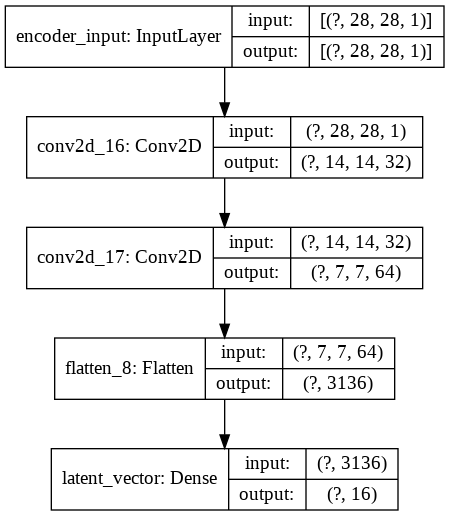

In [192]:
# instantiate encoder model
encoder = Model(inputs,
                latent,
                name='encoder')
encoder.summary()
plot_model(encoder,
           to_file='encoder.png',
           show_shapes=True)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense_12 (Dense)             (None, 3136)              53312     
_________________________________________________________________
reshape_8 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

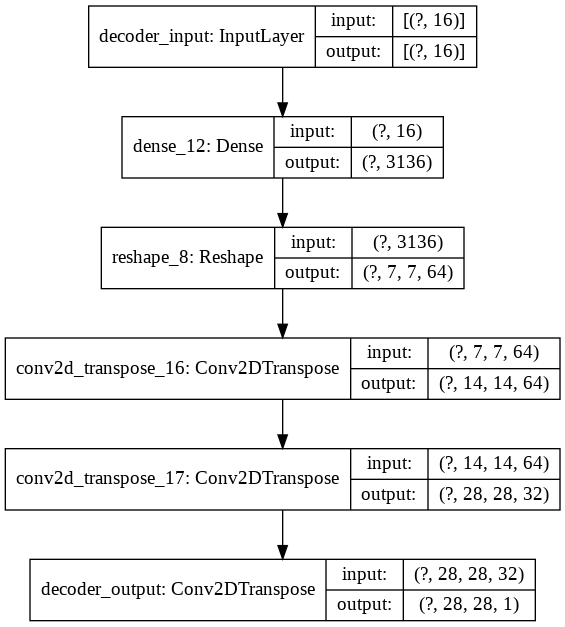

In [193]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

# reconstruct the input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True)



In [194]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name='autoencoder')
autoencoder.summary()
plot_model(autoencoder,
           to_file='autoencoder.png',
           show_shapes=True)

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')



Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                69008     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


In [195]:
# train the autoencoder
autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs=10,
                batch_size=batch_size)



Epoch 1/10
239/239 [==============================] - 85s 357ms/step - loss: 0.0673 - val_loss: 0.0267
Epoch 2/10
239/239 [==============================] - 85s 355ms/step - loss: 0.0175 - val_loss: 0.0136
Epoch 3/10
239/239 [==============================] - 85s 355ms/step - loss: 0.0127 - val_loss: 0.0119
Epoch 4/10
239/239 [==============================] - 85s 354ms/step - loss: 0.0113 - val_loss: 0.0107
Epoch 5/10
239/239 [==============================] - 85s 354ms/step - loss: 0.0105 - val_loss: 0.0101
Epoch 6/10
239/239 [==============================] - 84s 352ms/step - loss: 0.0099 - val_loss: 0.0097
Epoch 7/10
239/239 [==============================] - 84s 352ms/step - loss: 0.0095 - val_loss: 0.0097
Epoch 8/10
239/239 [==============================] - 84s 352ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 9/10
239/239 [==============================] - 84s 352ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 10/10
239/239 [==============================] - 84s 350ms/step - l

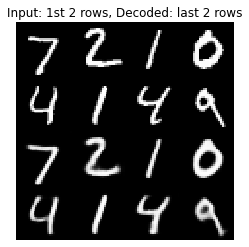

In [196]:
# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test)

# display the 1st 8 test input and decoded images
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()

In [228]:
# extract the trained encoder
encoder = Model(autoencoder.input, autoencoder.layers[-2].output)

In [229]:
# getting features of the test data and clustering it
feature_vectors = encoder.predict(x_test)
km = KMeans(n_clusters = 10, random_state = 15, algorithm = "elkan")
km.fit(feature_vectors)

KMeans(algorithm='elkan', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=15, tol=0.0001, verbose=0)

My take on hungarian algorithm

In [230]:
# Step 1: get maximum number of occurences of each true label with every cluster
# Step 2: use hungarian algorithm to find label of those with maximum occurences
# Step 3: assign that to be the label of that cluster

number_to_word = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

# Initializing the bipartite graph
G = {}
for i in range(10):
  if i not in G.keys():
    G[number_to_word[i]] = {}
    for j in range(10):
      G[number_to_word[i]][str(j)] = 0

print(G)

{'zero': {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0}, 'one': {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0}, 'two': {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0}, 'three': {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0}, 'four': {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0}, 'five': {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0}, 'six': {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0}, 'seven': {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0}, 'eight': {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0}, 'nine': {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0}}


In [231]:
# populating the bipartite graph
for i in range(len(x_test)):
  G[number_to_word[y_test[i]]][str(km.labels_[i])] += 1

print(G)

{'zero': {'0': 2, '1': 5, '2': 830, '3': 7, '4': 14, '5': 2, '6': 116, '7': 0, '8': 3, '9': 1}, 'one': {'0': 628, '1': 3, '2': 0, '3': 0, '4': 1, '5': 501, '6': 2, '7': 0, '8': 0, '9': 0}, 'two': {'0': 53, '1': 14, '2': 23, '3': 16, '4': 17, '5': 42, '6': 16, '7': 824, '8': 5, '9': 22}, 'three': {'0': 52, '1': 796, '2': 9, '3': 1, '4': 84, '5': 4, '6': 1, '7': 44, '8': 8, '9': 11}, 'four': {'0': 34, '1': 0, '2': 2, '3': 421, '4': 1, '5': 11, '6': 29, '7': 1, '8': 483, '9': 0}, 'five': {'0': 4, '1': 312, '2': 22, '3': 25, '4': 476, '5': 3, '6': 22, '7': 1, '8': 26, '9': 1}, 'six': {'0': 19, '1': 1, '2': 31, '3': 4, '4': 21, '5': 20, '6': 852, '7': 3, '8': 7, '9': 0}, 'seven': {'0': 39, '1': 0, '2': 1, '3': 60, '4': 1, '5': 60, '6': 0, '7': 9, '8': 104, '9': 754}, 'eight': {'0': 97, '1': 112, '2': 13, '3': 27, '4': 593, '5': 18, '6': 18, '7': 11, '8': 60, '9': 25}, 'nine': {'0': 39, '1': 11, '2': 6, '3': 398, '4': 7, '5': 8, '6': 1, '7': 2, '8': 486, '9': 51}}


In [232]:
# applying the algorithm

hungarian = algorithm.find_matching(G, matching_type = 'max', return_type = 'list' )

# display the actual labels of each cluster
# format: ((actual label, cluster number), number of occurences)
print(hungarian)

[(('two', '7'), 824), (('three', '1'), 796), (('six', '6'), 852), (('nine', '8'), 486), (('seven', '9'), 754), (('eight', '4'), 593), (('four', '3'), 421), (('one', '0'), 628), (('five', '5'), 3), (('zero', '2'), 830)]


In [233]:
# testing accuracy
cluster_labels = [i for i in range(10)]
for cluster in hungarian:
  cluster_labels[int(cluster[0][1])] = number_to_word.index(cluster[0][0])

correct = 0
total = len(km.labels_)

for i in range(len(km.labels_)):
  if cluster_labels[km.labels_[i]] == y_test[i]:
    correct += 1

print(f'''
Results on train data:
Correct predictions: {correct}
Total: {total}
Accuracy: {correct/total * 100}%
''')


Results on train data:
Correct predictions: 6187
Total: 10000
Accuracy: 61.870000000000005%

